## Hopper Quant Analyst Exercise


In the following, I am analyzing flight booking data to implement a simple model that recommends whether to buy a round trip flight ticket from Boston to Cancun on a certain look-up date or to wait for cheaper ticket prices on a future booking date. For the ~500 word discussion please scroll to the bottom of this notebook. 

In [1]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The code (Python 3) for this presentation is by default hidden for easier reading.
To toggle the code on/off, click <a href="javascript:code_toggle()">here</a>.''')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from datetime import timedelta

### Data set information

Let's first take a look at the size and type of data available.

In [3]:
# ---------- Analyze data ---------- #
data = pd.read_csv('boscun-longitudinal.csv')
print(data.info())
n_unique = data.search_id.unique().shape[0]
print('\nNumber of unique search IDs: ' + str(n_unique))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3009408 entries, 0 to 3009407
Data columns (total 26 columns):
search_id                       object
trip_index                      int64
received_date                   object
received_ms                     int64
origin                          object
destination                     object
total_usd                       float64
pax_type                        object
refundable                      float64
validating_carrier              object
departure_odate                 object
departure_ms                    int64
outgoing_duration               int64
outgoing_stops                  int64
return_odate                    object
return_ms                       int64
returning_duration              int64
returning_stops                 int64
major_carrier_id                object
total_stops                     int64
advance                         int64
length_of_stay                  int64
includes_saturday_night_stay    bool
a

The data set consists of a total of 3,009,408 search results with each 26 variables. For this illustration, I will build a simple model that only considers the booking date, departure date and return date to make price predictions. When developing a model for production, however, additional features should be included (more on that in the discussion section). I will only consider the cheapest flight for each search ID (assuming the user has no preference on his/her flight other than getting the cheapest deal on the specified dates) which reduces the data set to 113,339 rows.


### Prepare data set for model training

To prepare the data for model training, I extract the costs of a trip ("total_usd") as target variable and extract the following features from each of the cheapest flights per search ID:

- days in advance (number of days between booking and departure)
- day of departure (month and day 'MM-DD')
- day of return (month and day 'MM-DD')
- weekday of departure (Monday - Sunday)
- weekday of return (Monday - Sunday)

For the dates, I am interested in the information on day and month of the year (because of an expected seasonality effect) and weekday (because the same date in a different year falls on a different weekday). For the extracted dates I am creating dummy variables because the model should not interpret the date as a numerical variable.

In [4]:
# ---------- Prepare data ---------- #
data = pd.read_csv('boscun-longitudinal.csv')

# Convert departure_odate and return_odate to day_date:
data['departure_day_date'] = data['departure_odate'].apply(lambda x: x[-5:])
data['return_day_date'] = data['return_odate'].apply(lambda x: x[-5:])
data['departure_weekday'] = pd.to_datetime(data['departure_odate'].apply(lambda x: x[-10:]))\
        .apply(lambda x: x.weekday())
data['return_weekday'] = pd.to_datetime(data['return_odate'].apply(lambda x: x[-10:]))\
        .apply(lambda x: x.weekday())

# Group data by search id, take minimum price of each search result:
data_grouped = data.groupby(['search_id', 'advance', 'departure_day_date', 'return_day_date', \
                            'departure_weekday', 'return_weekday'])['total_usd'].min()
data_grouped = pd.DataFrame(data_grouped).reset_index()

# Create dummy variables from day of year and day of week:
df_departure_weekday = pd.get_dummies(data_grouped['departure_weekday'], sparse=True)
df_return_weekday = pd.get_dummies(data_grouped['return_weekday'], sparse=True)
df_departure_date = pd.get_dummies(data_grouped['departure_day_date'], sparse=True)
df_return_date = pd.get_dummies(data_grouped['return_day_date'], sparse=True)

# Create training and test data:
X = np.array(pd.concat([data_grouped['advance'], df_departure_weekday, df_return_weekday, 
                        df_departure_date, df_return_date], axis=1))
y = np.array(data_grouped['total_usd'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

### Train and evaluate model (Random Forest Regressor)

Let's train a simple random forest regressor on 90% of the data while using 10% for testing and evaluate it with mean squared error (MSE) and R-squared score (R2). When training and testing a variety of models with a variety of hyper parameters these metrics would be used to assess which model performs best.

To give a more interpretable assessment of model performance, I am also evaluating the accuracy when grouping the costs into USD \\$25 buckets (eg. \\$0-\\$25, \\$25-\\$50, etc.). This means a prediction is deemed accurate if the predicted result falls into the same \\$25 bucket as the actual costs.

In [5]:
# ---------- Build and train model ---------- #
rf = RandomForestRegressor()
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)

In [6]:
# ---------- Evaluate model ---------- #
# divide y_true and y_pred into $25 buckets
y_train_25 = np.array([int(y / 25) for y in y_train])
y_test_25 = np.array([int(y / 25) for y in y_test])
y_train_pred_25 = np.array([int(y / 25) for y in y_train_pred])
y_test_pred_25 = np.array([int(y / 25) for y in y_test_pred])

# calculate metrics:
r2_score_train = r2_score(y_train, y_train_pred)
r2_score_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
accuracy_train = accuracy_score(y_train_25, y_train_pred_25)
accuracy_test = accuracy_score(y_test_25, y_test_pred_25)
print('---------- Random Forest train and test results ----------')
print('MSE training set: ' + str(int(mse_train)))
print('MSE test set:     ' + str(int(mse_test)))
print('R2 score training set: ' + str(np.round(r2_score_train, 3)))
print('R2 score test set:     ' + str(np.round(r2_score_test, 3)))
print('Accuracy training set: ' + str(np.round(accuracy_train, 3)))
print('Accuracy test set:     ' + str(np.round(accuracy_test, 3)))

---------- Random Forest train and test results ----------
MSE training set: 2056
MSE test set:     5640
R2 score training set: 0.894
R2 score test set:     0.724
Accuracy training set: 0.511
Accuracy test set:     0.346


The test accuracy of ~35% shows that there is certainly room for improvement. This can be done through including additional features, using more data, testing a variety of models and tuning hyperparameters (see Discussion). Furthermore, hyperparameter tuning would need to be conducted to reduce overfitting.


### Use model for prediction

Below I am using a sample case with a specified hypothetical look-up date, departure date and return date to give a recommendation on timing for ticket purchase. For this example, let's assume the user is interested in booking a trip from Boston to Cancun for the time around July 4th, 2019:

- Look-up date: 3/23/19
- Departure date: 7/3/19
- Return date: 7/8/19

In [7]:
# Function to convert input info (booking date, departure date, return date) to input vector for prediction
def get_X(days_advance, departure_date, return_date):
    departure_weekday = pd.to_datetime(departure_date).weekday()
    df1_departure_weekday = pd.DataFrame({departure_weekday: [1]})
    df1_departure_weekday = df1_departure_weekday.reindex(columns = df_departure_weekday.columns, fill_value=0)
    return_weekday = pd.to_datetime(return_date).weekday()
    df1_return_weekday = pd.DataFrame({return_weekday: [1]})
    df1_return_weekday = df1_return_weekday.reindex(columns = df_return_weekday.columns, fill_value=0)
    departure_date = departure_date[-5:]
    df1_departure_date = pd.DataFrame({departure_date: [1]})
    df1_departure_date = df1_departure_date.reindex(columns = df_departure_date.columns, fill_value=0)
    return_date = return_date[-5:]
    df1_return_date = pd.DataFrame({return_date: [1]})
    df1_return_date = df1_return_date.reindex(columns = df_return_date.columns, fill_value=0)
    x = np.array([days_advance] + list(df1_departure_weekday.values.reshape(-1)) + \
                    list(df1_return_weekday.values.reshape(-1)) + \
                    list(df1_departure_date.values.reshape(-1)) + \
                    list(df1_return_date.values.reshape(-1))).reshape(1, -1)
    return x

In [8]:
# Specify inputs:
booking_date = '2019-03-23'
departure_date = '2019-07-03'
return_date = '2019-07-08'

# Predict results for each day between 'booking_date' and 'departure_date':
days_advance = (pd.to_datetime(departure_date) - pd.to_datetime(booking_date)).days
dates, price_pred = [], []
for day_advance in range(days_advance, 0, -1):
    dates.append((pd.to_datetime(departure_date) - timedelta(day_advance)).date())
    x = get_X(day_advance, departure_date, return_date)
    price_pred.append(rf.predict(x)[0])
    price_perc = [price / price_pred[0] * 100 for price in price_pred]
min_price = min(price_perc)
best_day = dates[min([i for i in range(len(price_perc)) if price_perc[i] == min_price])]

---------- Inputs ----------
Day today:     2019-03-23
Departure day: 2019-07-03
Return day:    2019-07-08

---------- Results ----------
Best day to buy: 2019-05-15



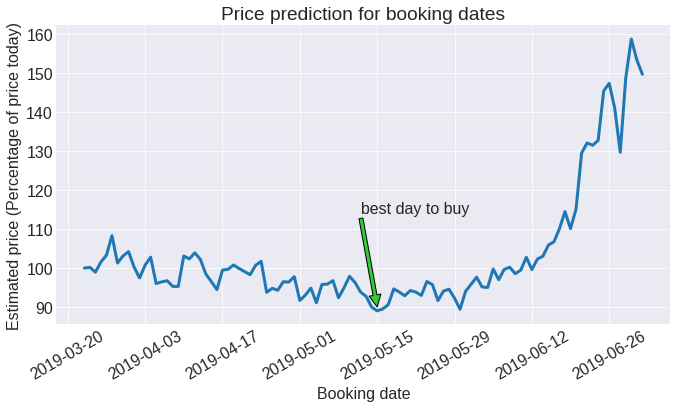

In [9]:
# Show prediction results:
print('---------- Inputs ----------')
print('Day today:     ' + str(booking_date))
print('Departure day: ' + str(departure_date))
print('Return day:    ' + str(return_date) + '\n')
print('---------- Results ----------')
print('Best day to buy: ' + str(best_day) + '\n')

# Plot results:
plt.rcParams.update({'figure.figsize': [11, 5.5], 'font.size': 16})
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots()
ax.plot(dates, price_perc, linewidth=3)
plt.xticks(rotation=30)
ax.annotate('best day to buy', xy=(best_day, min_price + 1), \
            xytext=(best_day - timedelta(3), min_price + 25),
            arrowprops=dict(facecolor='limegreen'))
ax.set_ylabel('Estimated price (Percentage of price today)')
ax.set_xlabel('Booking date')
ax.set_title('Price prediction for booking dates')
plt.show()

In this example, the predictive model suggests to wait with the ticket purchase until around mid May. Prices are expected to decrease by ~10-20% until then. Starting around mid June, however, prices are expected to increase significantly.


### Discussion


For this case study I trained a model that uses the number of days before departure as well as the month / day and the weekday of the departure and return day to predict the minimum prize in the search result. I used a random forest regressor that yielded an R-squared score of 0.72 and an accuracy (when divided in \\$25 buckets) of 35\% on the test set.

To illustrate how the model works, I then used a specified look-up, departure, and return date to predict the expected ticket price for each booking day between look-up and departure and return the date of the minimum expected ticket price as recommended purchase date.

This case study shows an approach of how to conceptually build and use such a model. However, before putting such a model in production, there are several additional factors to consider:


- Additional input features should be considered. Such features include: number of stops, validating carrier, duration of the flight, time of takeoff, etc. (We would train the model with a different subselection of features to determine which ones improve the model performance). Considering more input features is expected to significantly improve the model, not only because of those features' correlation with the ticket price, but also because we would be splitting the data into more groups and therefore leverage more of the available data for training. 


 - Including additional features would not mean that all of these features need to be specified by the user when searching for a flight. Instead, when running the model in production, the model would extract the relevant features from actual search results and run the model to predict future prices accordingly.


- To further improve the model we should, if available, collect more data for training. Having multiple years of training data would also reveal how price patterns before departure have been changing over time.


- Regarding model building, training and validation, I would suggest testing various regression tree based models in addition to random forests, such as GBM or XGBoost. Support vector machines might be worth a shot, however, with a large amount of features they might need too long to train. Neural networks might be interesting as well, especially as more data becomes available and more features are being considered. For each of the models rigorous hyper parameter tuning with cross-validation would be necessary to find the optimal solution with minimal overfitting.


- While I used the model to predict the exact ticket price (as a percentage of the ticket price on the initial booking date) we might group the results into certain buckets (for example price increase 0-5\%, 5-10\% etc.). This approach might be better than predicting an exact price since our model can only achieve a certain level of accuracy.